# 多臂老虎机问题

多臂老虎机，每一臂都有其收益的均值。如果想赢得最多的钱，最朴素的做法是先通过实现找出收益均值最多的臂，然后只选择该臂即可。

每一次选择都是独立的，但是选择之前需要权衡 exploration 与 exploitation。前者尽可能地进行随机尝试，后者则选择“当前”均值最多的臂。

In [9]:
import numpy as np
from scipy import stats
import random
import matplotlib.pyplot as plt

n = 10

老虎机的每个臂的奖励分布实现如下。每个臂的收益概率作为入参，比如概率是 0.7，由于在这个问题里，设定最大收益为 10，那么在 0.7 的概率下，理应得到接近 7 的收益，所以在下面的实验验证里，选择 2000 次该臂，得到的平均收益正是 7。

In [10]:
def get_reward(prob, n=10):
    reward = 0
    for i in range(n):
        if random.random() < prob:
            reward += 1
    return reward

In [11]:
np.mean([get_reward(0.7) for _ in range(2000)])

6.944

理论上我们需要将每次操作的选择与收益记录成 `(action, reward)` 对，但在这个问题里，我们做选择的时候是根据过往收益的均值来进行的，所以我们只要一直保持对均值的更新即可，并不需要将每次结果记录下来。为了保持对均值的更新，我们需要记录每个臂的选择次数，以及其最新的收益均值。

In [12]:
record = np.zeros((n, 2))
record

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [13]:
def update_record(record, action, r):
    new_r = (record[action, 0] * record[action, 1] + r) / (record[action, 0] + 1)
    record[action, 0] += 1
    record[action, 1] = new_r
    return record

In [14]:
def get_best_arm(record):
    arm_index = np.argmax(record[:, 1], axis=0)
    return arm_index

## $\varepsilon$-greedy 策略

下面对老虎机操作 500 次，并展示收益均值的变化。可以看到收益均值很快便收敛了。由于采用了 $\varepsilon$-greedy 的算法，有 80% 的概率选择最优臂，其余概率随机选择，所以整体的收益期望是 $\text{exp}_{\text{best}} * 0.8 + \text{exp}_{\text{others}} * 2$，从下图可以看出收敛值为 0.9 附近。

probs:  [0.69646919 0.28613933 0.22685145 0.55131477 0.71946897 0.42310646
 0.9807642  0.68482974 0.4809319  0.39211752]


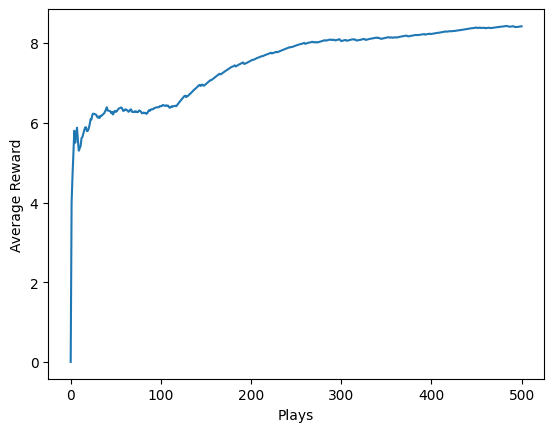

In [23]:
np.random.seed(123)

record = np.zeros((n, 2))
probs = np.random.rand(n)
eps = 0.2
episodes = 500
# track mean rewards
rewards = [0]
choices = np.zeros(n)

print('probs: ', probs)

for i in range(episodes):
    if random.random() > eps:
        choice = get_best_arm(record)
    else:
        choice = np.random.randint(n)

    r = get_reward(probs[choice])
    record = update_record(record, choice, r)
    mean_reward = ((i + 1) * rewards[-1] + r) / (i + 2)
    rewards.append(mean_reward)
    choices[choice] += 1

plt.xlabel('Plays')
plt.ylabel('Average Reward')
plt.plot(np.arange(len(rewards)), rewards, label='Mean Rewards')

从下图可以看到，因为最高收益的臂是第 6 个，所以选择 6 的次数是最多的。

<BarContainer object of 10 artists>

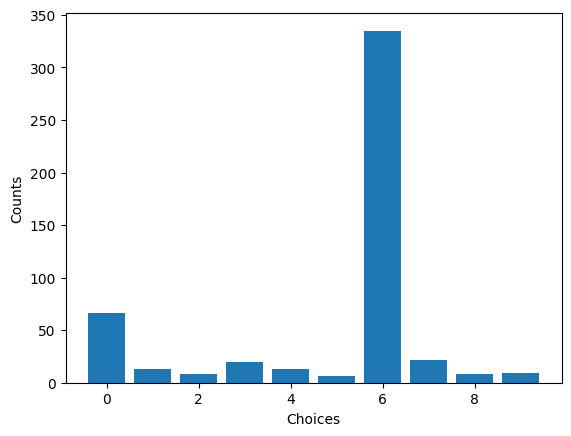

In [22]:

plt.xlabel('Choices')
plt.ylabel('Counts')
plt.bar(np.arange(len(choices)), choices, label='Choices Count')

## Softmax 策略

与 $\varepsilon$-greedy 不同的是，Softmax 不会随机选择，而是通过一种方式将随机动作选择转化为从一个概率分布中选择动作。这个概率分布根据过往的动作收益来生成。过去收益更高的动作具有更高的概率，反之则是更低的概率甚至为 0。Softmax 的计算公式如下所示

$$
\text{Pr}(A) = 
    \frac{
        e^{Q_k(A)/\tau}
    }{
        \sum^n_{i=1} e^{Q_k(i)/\tau}
    }
$$

实际上是对每个动作的 Q 值取 $e$ 指数，然后进行标准化，保证所有值之和为 1。其中的 $\tau$ 是 temperature，当 $\tau$ 越大的时候，每个 Q 值的差距会被缩小，让分布更为平均，反之则保留动作之间的差别（考虑 $\tau = 1$ 的情况）。

In [24]:
def softmax(action_values, tau=1.12):
    exp = np.exp(action_values / tau)
    return exp / np.sum(exp)